In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

#keras
import keras.backend as K
import tensorflow as tf 
    
import os
import sys

sns.set_theme()

In /home/MCB/zkarwowska/anaconda3/envs/basic_env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/MCB/zkarwowska/anaconda3/envs/basic_env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/MCB/zkarwowska/anaconda3/envs/basic_env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/MCB/zkarwowska/anaconda3/envs/basic_env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be re

In [2]:
MODULE_PATH = os.path.abspath('/storage/zkarwowska/SONATA_PROJECT/clean_code/data_preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit

MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project') # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from utils.measures import calculate_spearman, calculate_nrmse, inter_dissimilarity

### 1. READ DATA

In [3]:
FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets/donorA_rarefied_interpolated_feces.csv'

In [4]:
df = pd.read_csv(FILE, index_col = [0])
df = df.sort_index()

### 2. PREPARE DATA

In [5]:
#filter
processing = MicrobiomeDataPreprocessing()
df_filtered = processing.filter_rare_features(df, 0.8)

#clr transform
clr_transformer = CLRTransformer(is_pseudo_global=True, axis=1)
df_filtered_clr = clr_transformer.fit_transform(df_filtered)

#make supervised
lag = 1
#df_filtered_supervised = processing.make_supervised(df_filtered, lag)
df_filtered_clr_supervised = processing.make_supervised(df_filtered_clr, lag)

#df_filtered_clr_supervised[df_filtered_supervised.filter(like = 'lag0').columns] = df_filtered_supervised.filter(like = 'lag0')

#split to train and test
split = MicrobiomeTraintestSplit(0.15)
train, test  = split.last_block_split(df_filtered_clr_supervised)

y_train, X_train = train.filter(like = 'lag0'), train.drop(train.filter(regex='lag0').columns, axis=1)
y_test, X_test = test.filter(like = 'lag0'), test.drop(test.filter(regex='lag0').columns, axis=1)

In [6]:
def inverse_clr(y_pred, x_test):
    
    y_pred_inv = np.exp(y_pred)*clr_transformer.gmean_[-x_test.shape[0]:].reshape(-1, 1)
    
    return y_pred_inv

In [7]:
y_test_true = inverse_clr(y_test, X_test)
y_test_true.columns = df_filtered.columns

naive = df_filtered.iloc[-(len(y_test_true)+lag):-lag]

### 3. DEFINE MODEL

In [8]:
def mlp(y_train, X_train, X_test, loss):
    
    l1 = 1e-4
    l2 = 1e-4
    
    input_size = X_train.shape[1]
    input_data = tf.keras.Input(shape=(input_size,))

    layer_1 = tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2))
    prediction = layer_1(input_data)
    output = tf.keras.layers.Dense(y_train.shape[1])(prediction)
    model = tf.keras.Model(input_data, output)
    
    model.compile(
        loss = loss,
        optimizer='Adam'
    )
    
    model_result = model.fit(X_train, y_train,
                                   epochs=150,
                                   batch_size=4,
                                   shuffle=False,
                                   verbose = 0)                                           
                                           
    
    pred = model.predict(X_test)
    
    return model_result, pred

### 4. TEST LOSS FUNCTIONS

#### 4.1 Mean Squared Error

In [9]:
mse_history, mse_prediction = mlp(y_train, X_train, X_test, tf.keras.losses.MeanSquaredError())
mse_prediction_inv = pd.DataFrame(inverse_clr(mse_prediction, X_test), columns = df_filtered.columns)

#### 4.2. Bray Curtis Loss

In [10]:
def BrayCurtisLoss(y_true, y_pred):
    
    '''
    
    Bray Curtis distance between y_true and y_pred.
    The Bray Curtis dissimilarity is used to quantify
    the differences in species populations between two
    different sites. 
    
    '''

    diff = tf.math.abs(y_true - y_pred)
    sum = tf.math.abs(y_true + y_pred)
    value = tf.reduce_sum(diff, axis=-1) / tf.reduce_sum(sum, axis=-1)

    return value

In [11]:
bc_history, bc_prediction = mlp(y_train, X_train, X_test, BrayCurtisLoss)
bc_prediction_inv = pd.DataFrame(inverse_clr(bc_prediction, X_test), columns = df_filtered.columns)

#### 4.3 Aitchison Distance Loss

In [12]:
def AitchinsonDistanceLoss(y_true, y_pred):
    
    '''
    
    Euclidean distance between CLR transformed data
    
    '''

    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [13]:
aitchinson_history, aitchinson_prediction = mlp(y_train, X_train, X_test, AitchinsonDistanceLoss)
aitchinson_prediction_inv = pd.DataFrame(inverse_clr(aitchinson_prediction, X_test), columns = df_filtered.columns)

#### 5. VISUALISE RESULTS

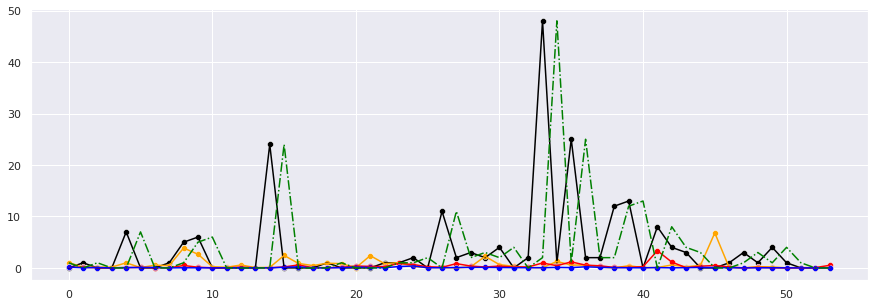

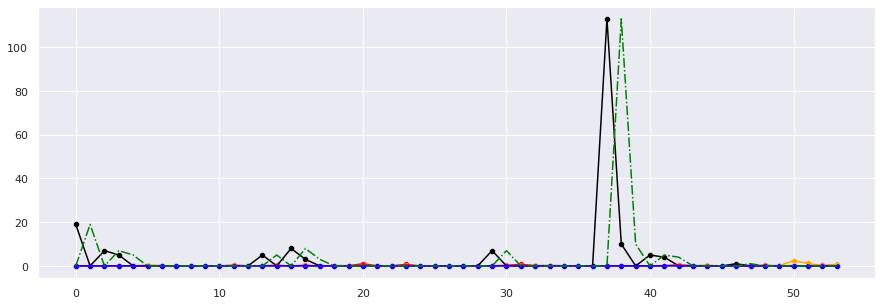

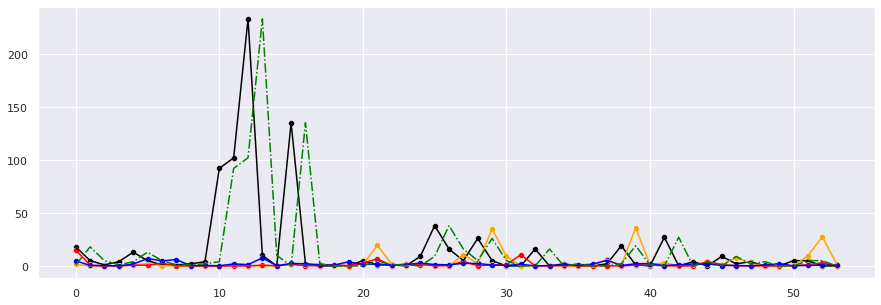

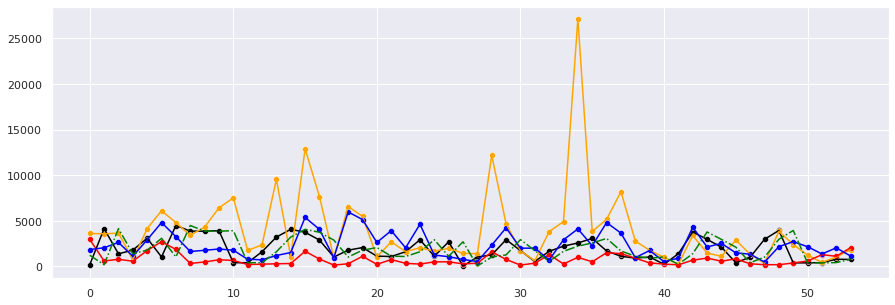

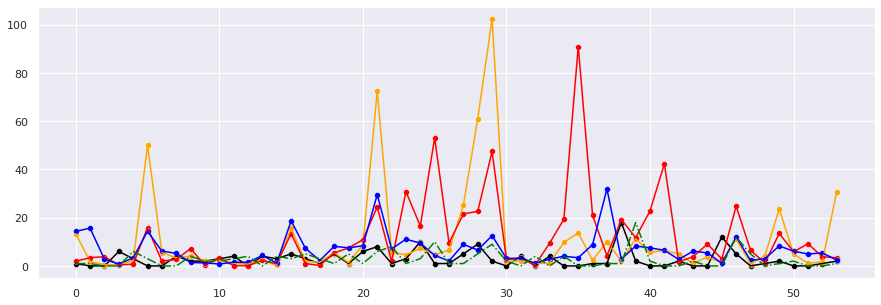

In [14]:
cols = df_filtered.iloc[:, 10:15]

for col in cols:
    

    plt.figure(figsize = [15, 5])

    idx = range(len(y_test_true.index))

    sns.lineplot(x = idx, y = y_test_true[col].values, color = 'black')
    sns.scatterplot(x = idx, y = y_test_true[col].values, color = 'black')

    sns.lineplot(x = idx, y = aitchinson_prediction_inv[col].values, color = 'orange')
    sns.scatterplot(x = idx, y = aitchinson_prediction_inv[col].values, color = 'orange')

    sns.lineplot(x = idx, y = mse_prediction_inv[col].values, color = 'red')
    sns.scatterplot(x = idx, y = mse_prediction_inv[col].values, color = 'red')

    sns.lineplot(x = idx, y = bc_prediction_inv[col].values, color = 'blue')
    sns.scatterplot(x = idx, y = bc_prediction_inv[col].values, color = 'blue')

    sns.lineplot(x = idx, y = naive[col].values, color = 'green', linestyle = '-.')


    plt.show()

#### 6. MEASURE FORECAST

#### 6.1 BRAY CURTIS DISTANCE

In [15]:
y_test.index, naive.index = range(len(y_test)), range(len(naive))
y_test.columns, naive.columns = df_filtered.columns, df_filtered.columns

mse_bc = inter_dissimilarity(y_test, pd.DataFrame(mse_prediction, columns = df_filtered.columns), 'bc')
mse_bc['loss'] = 'mse'

bc_bc = inter_dissimilarity(y_test, pd.DataFrame(bc_prediction, columns = df_filtered.columns), 'bc')
bc_bc['loss'] = 'bc'

ai_bc = inter_dissimilarity(y_test, pd.DataFrame(aitchinson_prediction, columns = df_filtered.columns), 'bc')
ai_bc['loss'] = 'aitchinson'


BC_DF = mse_bc.append(bc_bc).append(ai_bc)

Text(0.5, 1.0, 'Bray Curtis between true and predicted timepoints - after CLR')

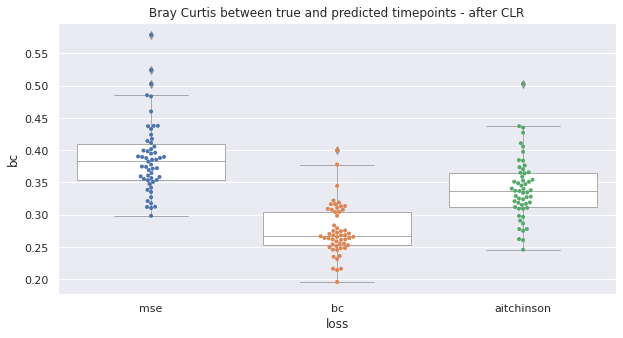

In [16]:
plt.figure(figsize = (10, 5))
sns.boxplot(data = BC_DF, x = 'loss', y = 'bc', color = 'white', linewidth = .8)
sns.swarmplot(data = BC_DF, x = 'loss', y = 'bc', s=4)

plt.title('Bray Curtis between true and predicted timepoints - after CLR')

Text(0.5, 1.0, 'Bray Curtis between true and predicted timepoints - after CLR')

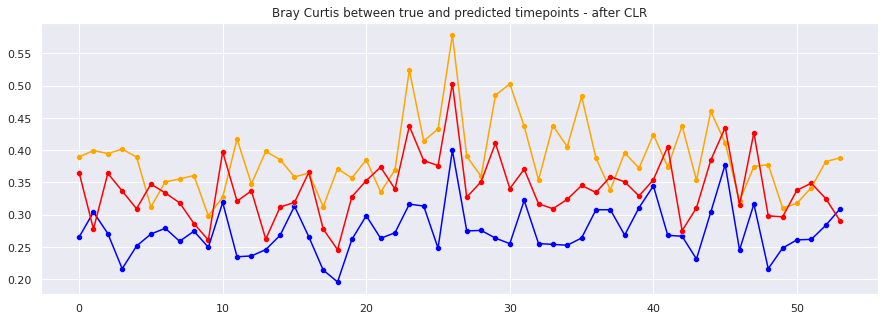

In [17]:
plt.figure(figsize = (15, 5))


sns.lineplot(x = mse_bc.index, y = mse_bc['bc'].values, color = 'orange')
sns.scatterplot(x = mse_bc.index, y = mse_bc['bc'].values, color = 'orange')


sns.lineplot(x = bc_bc.index, y = bc_bc['bc'].values, color = 'blue')
sns.scatterplot(x = bc_bc.index, y = bc_bc['bc'].values, color = 'blue')

sns.lineplot(x = ai_bc.index, y = ai_bc['bc'].values, color='red')
sns.scatterplot(x = ai_bc.index, y = ai_bc['bc'].values, color='red')

plt.title('Bray Curtis between true and predicted timepoints - after CLR')

#### 6.2. Spearman correlation

In [18]:
y_test.index, naive.index = range(len(y_test)), range(len(naive))
y_test.columns, naive.columns = df_filtered.columns, df_filtered.columns

mse_rho = calculate_spearman(y_test, pd.DataFrame(mse_prediction, columns = df_filtered.columns), 'rho')
mse_rho['loss'] = 'mse'

bc_rho = calculate_spearman(y_test, pd.DataFrame(bc_prediction, columns = df_filtered.columns), 'rho')
bc_rho['loss'] = 'bc'

ai_rho = calculate_spearman(y_test, pd.DataFrame(aitchinson_prediction, columns = df_filtered.columns), 'rho')
ai_rho['loss'] = 'aitchinson'


RHO_DF = mse_rho.append(bc_rho).append(ai_rho)

Text(0.5, 1.0, 'Spearman correlation between true and predicted bacteria fluctuations - after CLR')

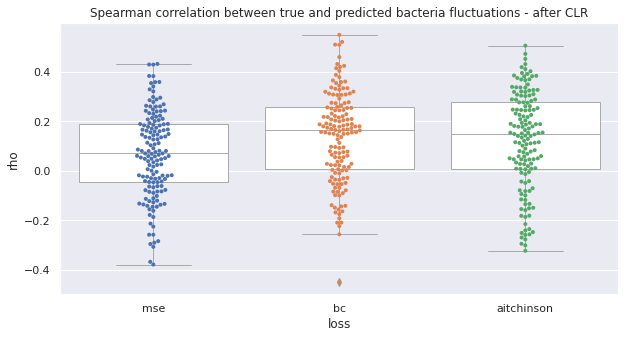

In [19]:
plt.figure(figsize = (10, 5))

sns.boxplot(data = RHO_DF, x = 'loss', y = 'rho', color = 'white', linewidth = .8)
sns.swarmplot(data = RHO_DF, x = 'loss', y = 'rho',  s = 4)

plt.title('Spearman correlation between true and predicted bacteria fluctuations - after CLR')